# Clasificación con Máquina de Vectores de Soporte y Redes de Neuronas

## Importamos las librerías necesarias

In [35]:
# Calculo y manipulación de datos
import pandas as pd
import numpy as np
from numpy.lib.function_base import average

# Modelizacion
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras import models
from keras import layers

# Utilidades
import os

# Visualizacion
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Descargar dataset
!rm /content/datasets_train.csv
!wget https://raw.githubusercontent.com/carseven/master-ai/main/machineLearning/lab2/datasets_train.csv

# Referencias
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
# https://stackabuse.com/deep-learning-in-keras-data-preprocessing/
# https://www.kaggle.com/sanchit2843/neuralnetworkkeras
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

# Que pandas muestre todas las columnas
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pylab.rcParams['figure.figsize'] = (16.0, 7.0)

--2021-02-06 21:20:12--  https://raw.githubusercontent.com/carseven/master-ai/main/machineLearning/lab2/datasets_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122402 (120K) [text/plain]
Saving to: ‘datasets_train.csv’

datasets_train.csv  100%[===================>] 119.53K  --.-KB/s    in 0.02s   

2021-02-06 21:20:12 (4.71 MB/s) - ‘datasets_train.csv’ saved [122402/122402]



## Cargar dataset

In [36]:
data = pd.read_csv('/content/datasets_train.csv')

## Análisis descriptivo de los datos

### Analisis inicial y distinción de los tipos de variables

In [37]:
data.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Explicar un poco el dataset y la caracteristicas de cada columna.
battery_power: Total energy a battery can store in one time measured in mAh
blue: Has bluetooth or not
clock_speed: speed at which microprocessor executes instructions
dual_sim: Has dual sim support or not
fc: front camera mega pixeles
four_g: has 4g or not
int_memory: Internal Memory in Gigabytes
m_dep: Mobile Depth in cm
mobile_wt: Weight of mobile phone
n_cores: Number of cores of processor
pc: Primary Camera mega pixels
px_height: Pixel Resolution Height
px_width: Pixel Resolution Width
ram: Random Access Memory in Megabytes
sc_h: Screen Height of mobile in cm
sc_w: Screen Width of mobile in cm
talk_time: longest time that a single battery charge will last when you are
three_g: Has 3G or not
touch_screen: Has touch screen or not
wifi: Has wifi or not
Columnas a predecir en la clasificacion.
price_range: This is the target variable with value of
0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).

Distingir variables númericas de las categoricas

In [39]:
cat_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen',
               'wifi', 'price_range']

num_columns = list(set(data.columns) - set(cat_columns))

print('Variables númericas:')
print(num_columns)
print('\n')
print('Variables categoricas:')
print(cat_columns)

Variables númericas:
['sc_w', 'clock_speed', 'battery_power', 'n_cores', 'm_dep', 'pc', 'sc_h', 'fc', 'mobile_wt', 'int_memory', 'talk_time', 'px_width', 'ram', 'px_height']


Variables categoricas:
['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']


### Datos estadísticos de las variables númericas

In [40]:
print('Datos estadíticos de las variables númericas:')
for column in num_columns:
    cuartiles = data[column].quantile([.25, .50, .75])

    print('Variable ' + column + ':')
    print('MAX:', data[column].max())
    print('MIN:', data[column].min())
    print('MEDIA:', data[column].mean())
    print('MEDIANA:', data[column].median())
    print('25%:', cuartiles.iloc[0])
    print('50%:', cuartiles.iloc[1])
    print('75%:', cuartiles.iloc[2])
    print('\n')

Datos estadíticos de las variables númericas:
Variable sc_w:
MAX: 18
MIN: 0
MEDIA: 5.767
MEDIANA: 5.0
25%: 2.0
50%: 5.0
75%: 9.0


Variable clock_speed:
MAX: 3.0
MIN: 0.5
MEDIA: 1.5222499999999983
MEDIANA: 1.5
25%: 0.7
50%: 1.5
75%: 2.2


Variable battery_power:
MAX: 1998
MIN: 501
MEDIA: 1238.5185
MEDIANA: 1226.0
25%: 851.75
50%: 1226.0
75%: 1615.25


Variable n_cores:
MAX: 8
MIN: 1
MEDIA: 4.5205
MEDIANA: 4.0
25%: 3.0
50%: 4.0
75%: 7.0


Variable m_dep:
MAX: 1.0
MIN: 0.1
MEDIA: 0.5017500000000017
MEDIANA: 0.5
25%: 0.2
50%: 0.5
75%: 0.8


Variable pc:
MAX: 20
MIN: 0
MEDIA: 9.9165
MEDIANA: 10.0
25%: 5.0
50%: 10.0
75%: 15.0


Variable sc_h:
MAX: 19
MIN: 5
MEDIA: 12.3065
MEDIANA: 12.0
25%: 9.0
50%: 12.0
75%: 16.0


Variable fc:
MAX: 19
MIN: 0
MEDIA: 4.3095
MEDIANA: 3.0
25%: 1.0
50%: 3.0
75%: 7.0


Variable mobile_wt:
MAX: 200
MIN: 80
MEDIA: 140.249
MEDIANA: 141.0
25%: 109.0
50%: 141.0
75%: 170.0


Variable int_memory:
MAX: 64
MIN: 2
MEDIA: 32.0465
MEDIANA: 32.0
25%: 16.0
50%: 32.0
75%: 48.

### Frecuencia de las variables categoricas

In [41]:
for column in cat_columns:
    print(f'Variable {column}:')
    print(f'Listado categorias: \n{data[column].unique()}')
    print(f'Frecuencia categorias: \n{data[column].value_counts()}')
    print('\n')

Variable blue:
Listado categorias: 
[0 1]
Frecuencia categorias: 
0    1010
1     990
Name: blue, dtype: int64


Variable dual_sim:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1019
0     981
Name: dual_sim, dtype: int64


Variable four_g:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1043
0     957
Name: four_g, dtype: int64


Variable three_g:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1523
0     477
Name: three_g, dtype: int64


Variable touch_screen:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1006
0     994
Name: touch_screen, dtype: int64


Variable wifi:
Listado categorias: 
[1 0]
Frecuencia categorias: 
1    1014
0     986
Name: wifi, dtype: int64


Variable price_range:
Listado categorias: 
[1 2 3 0]
Frecuencia categorias: 
3    500
2    500
1    500
0    500
Name: price_range, dtype: int64




### Distribución de las variables númericas

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

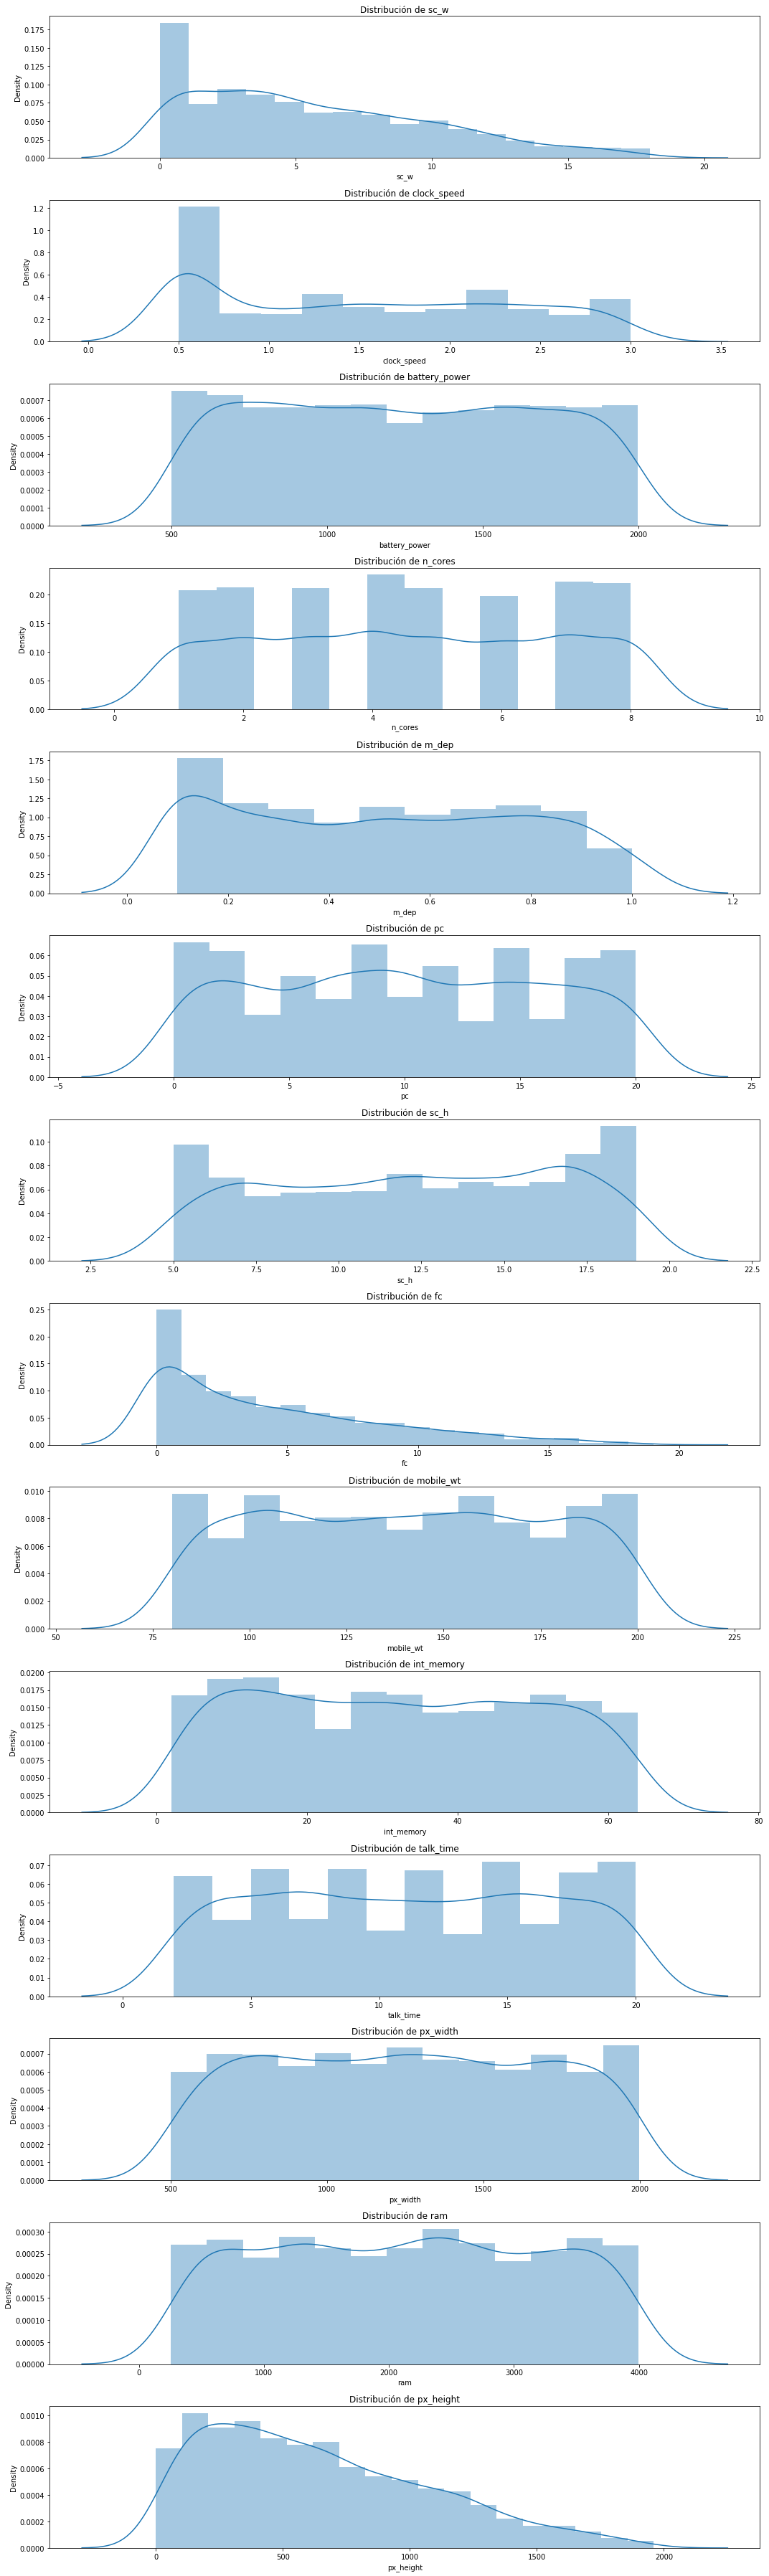

In [42]:
fig, axs = plt.subplots(len(num_columns), 1, figsize=(15, 50))

count = 0
for column in num_columns:
    fp = sb.distplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    count += 1

plt.tight_layout();

### Distribución de las variables categoricas

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

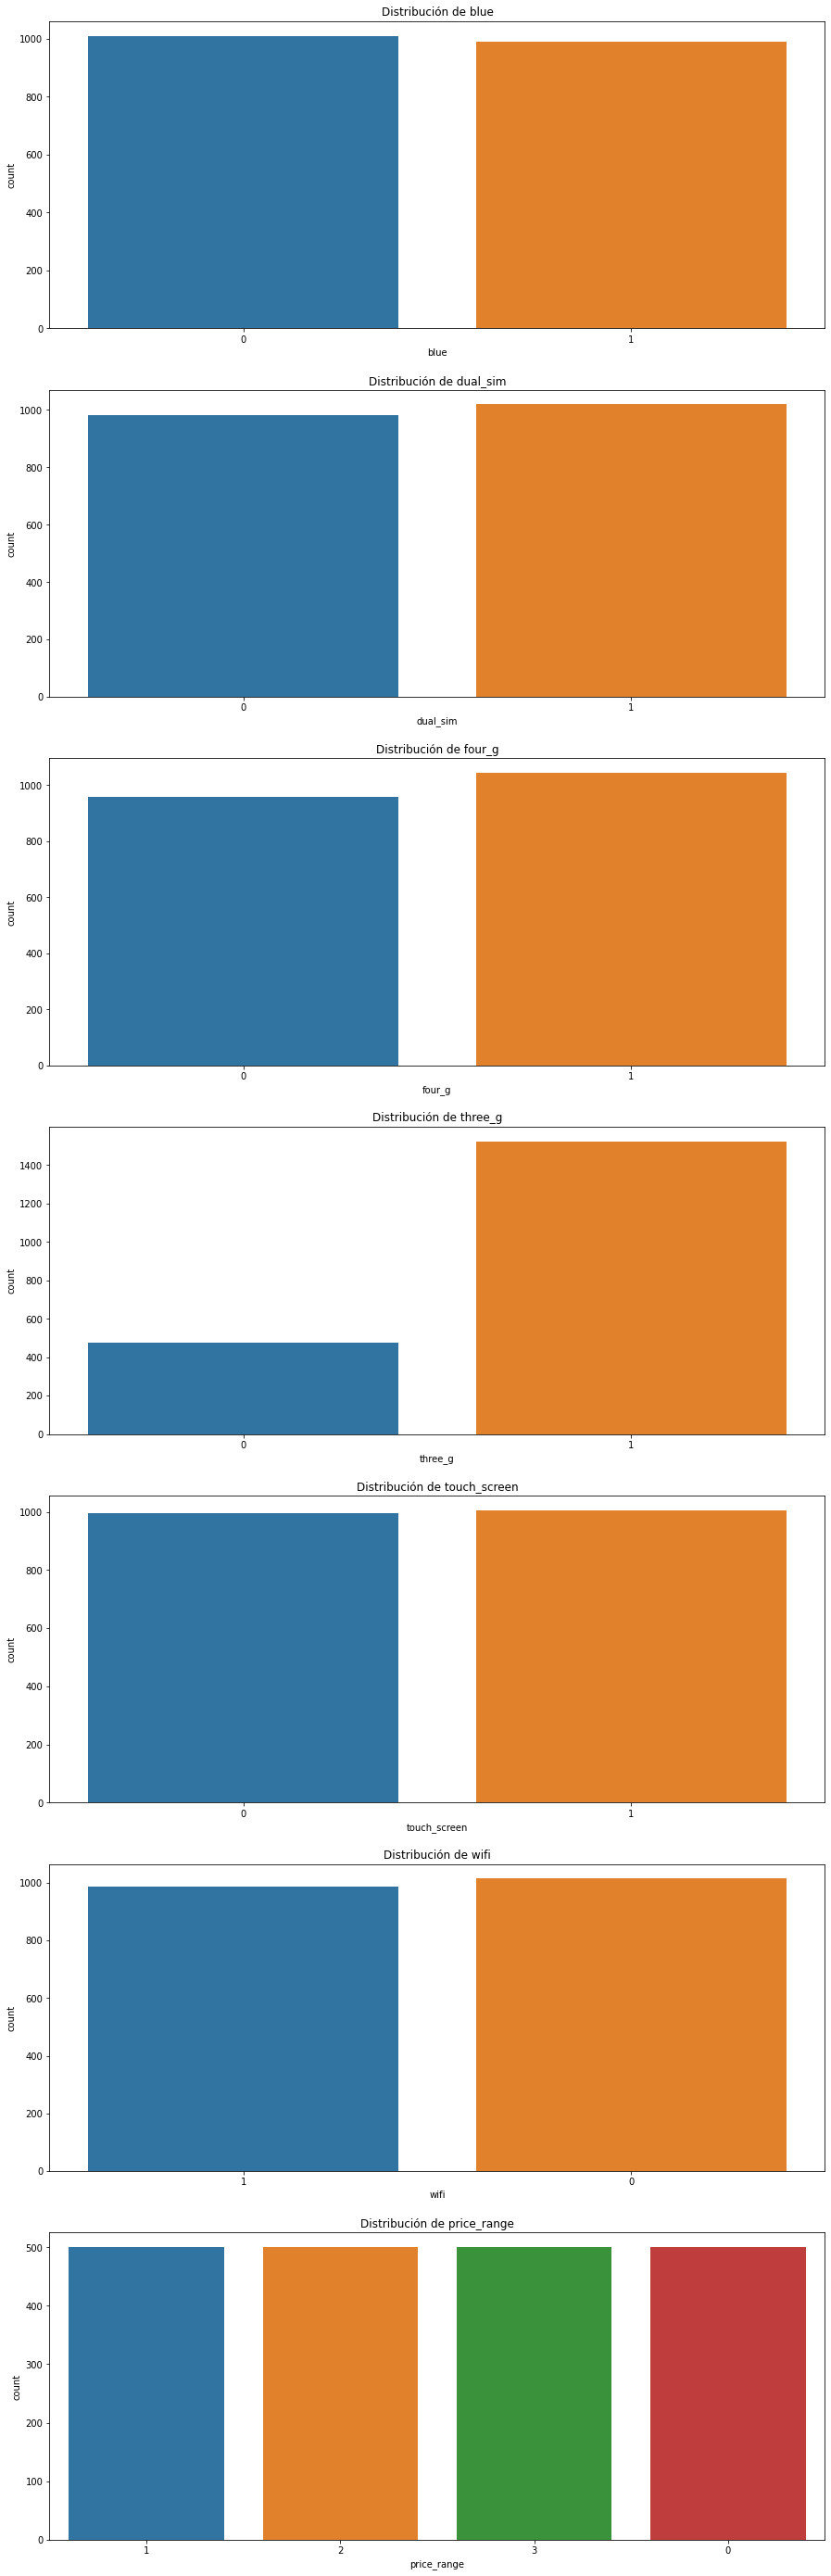

In [43]:
fig, axs = plt.subplots(len(cat_columns), 1, figsize=(15, 50))

count = 0
for column in cat_columns:
    fp = sb.countplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    fp.set_xticklabels(data[column].unique())
    count += 1

### Matriz de correlación

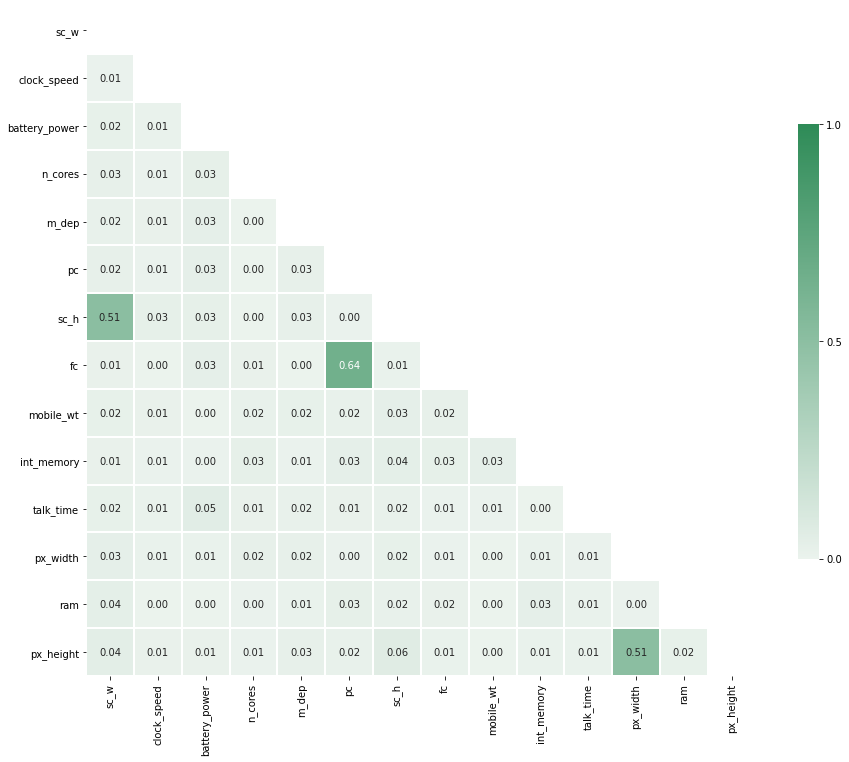

In [44]:
# Calcular correlacion de las variables numericas.
df_matrix_corr = data[num_columns].corr(method='pearson').abs()

# Triangulo inferior de la matrix de correlacion
mask = np.triu(np.ones(df_matrix_corr.shape)).astype(np.bool)

# Grafico de la matriz de correlacion
f, ax = plt.subplots(figsize=(15, 20))
ax.set_yticklabels(df_matrix_corr.columns[1:], rotation=0)
ax.set_xticklabels(df_matrix_corr.columns[:-1], rotation=45)
heatmap = sb.heatmap(
    df_matrix_corr,
    mask=mask,
    square=True,
    linewidths=1,
    cmap=sb.light_palette('seagreen', as_cmap=True),
    cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={"size": 10},
    fmt=".2f"
)

In [45]:
umbral = 0.75
corr_stack = df_matrix_corr.where(mask).stack().reset_index()
corr_stack.columns = ['Row', 'Column', 'Correlation Value']
corr_75 = corr_stack[(corr_stack['Correlation Value'] > umbral) &
                     (corr_stack['Correlation Value'] < 1)]
corr_75 = corr_75.sort_values(
    by='Correlation Value',
    kind="quicksort",
    ascending=False).drop_duplicates(keep='first')
print(corr_75)

Empty DataFrame
Columns: [Row, Column, Correlation Value]
Index: []


Se aprecia claramente una relación en las variables como pc, fc. sc_w y sc_h,
px_width y px_px_height
Mostrar distribuciones, comparar las distribuciones con estas.
No se ha encontrado ninguna correlación que supere el 75%

### Tratamiento de missing

In [46]:
percent_null = (data.isnull().sum() / len(data)) * 100
print(percent_null)

battery_power    0.0
blue             0.0
clock_speed      0.0
dual_sim         0.0
fc               0.0
four_g           0.0
int_memory       0.0
m_dep            0.0
mobile_wt        0.0
n_cores          0.0
pc               0.0
px_height        0.0
px_width         0.0
ram              0.0
sc_h             0.0
sc_w             0.0
talk_time        0.0
three_g          0.0
touch_screen     0.0
wifi             0.0
price_range      0.0
dtype: float64


## Máquina de Vectores de Soporte

### Pre-procesado

In [47]:
x = data.drop(columns='price_range')
y = data['price_range']

Hold out

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print("Datos de entrenamiento:")
print(f"Samples: {x_train.shape}")
print(f"Labels: {y_train.shape}\n")
print("Datos de test:")
print(f"Samples: {x_test.shape}")
print(f"Labels: {y_test.shape}\n")

Datos de entrenamiento:
Samples: (1600, 20)
Labels: (1600,)

Datos de test:
Samples: (400, 20)
Labels: (400,)



## Modelo

In [49]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(), parameters, scoring='accuracy', cv=5)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}


In [50]:
svm_model = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], random_state=42)
svm_model = svm_model.fit(x_train, y_train)
predicted = svm_model.predict(x_test)
print(predicted)

[0 2 1 3 1 1 2 0 3 1 0 1 2 3 3 2 3 3 1 0 0 2 1 2 0 1 3 3 2 0 0 0 3 0 1 1 2
 0 3 0 2 3 2 0 2 3 2 1 3 1 3 1 0 0 1 1 1 3 0 0 1 3 3 1 0 0 3 3 1 2 2 2 0 1
 2 0 1 3 2 2 3 2 1 0 1 3 1 3 3 0 3 3 2 1 3 2 2 3 1 1 0 0 1 0 1 3 2 0 1 1 0
 0 3 1 3 2 3 2 0 2 1 3 2 1 3 3 0 2 0 2 3 0 2 2 0 3 1 0 0 2 2 1 2 2 0 0 0 1
 1 2 3 1 1 0 2 2 0 1 0 2 2 3 3 2 1 0 1 2 2 3 3 0 1 0 3 1 1 2 1 0 0 0 0 0 3
 2 0 3 0 0 0 0 1 3 3 1 0 1 1 1 1 2 2 3 3 3 1 2 0 0 0 2 1 1 3 1 1 2 1 1 3 2
 3 0 0 2 1 3 0 1 2 0 2 3 2 0 1 3 3 0 1 3 2 3 0 3 1 2 3 3 2 1 1 3 3 1 3 3 3
 3 3 0 1 2 2 2 3 0 2 3 2 2 2 1 0 1 0 2 3 1 3 1 1 3 1 2 0 0 3 0 1 2 3 3 3 1
 1 0 1 3 3 0 1 2 2 0 3 3 2 3 2 3 2 0 2 1 1 1 0 0 0 3 3 3 1 0 1 0 1 2 3 0 3
 3 2 1 3 0 0 2 1 3 2 0 1 1 1 1 1 3 2 0 0 3 3 0 3 0 0 2 0 1 2 2 2 3 0 3 2 3
 3 3 3 2 1 1 0 3 1 3 3 0 2 3 2 3 3 3 0 0 2 3 0 0 2 3 2 1 1 2]


In [56]:
def counts_from_confusion(confusion_matrix):
    count = []

    # Iterate through classes and store the counts
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]

        fn_mask = np.zeros(confusion_matrix.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion_matrix, fn_mask))

        fp_mask = np.zeros(confusion_matrix.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion_matrix, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion_matrix, tn_mask))

        count.append({'Clase': i,
                      'TP': tp,
                      'FN': fn,
                      'FP': fp,
                      'TN': tn})

    tp = (count[0]['TP'] + count[1]['TP'] + count[2]
          ['TP'] + count[3]['TP'])
    tn = (count[0]['TN'] + count[1]['TN'] + count[2]
          ['TN'] + count[3]['TN'])
    fp = (count[0]['FP'] + count[1]['FP'] + count[2]
          ['FP'] + count[3]['FP'])
    fn = (count[0]['FN'] + count[1]['FN'] + count[2]
          ['FN'] + count[3]['FN'])

    return tp, tn, fp, fn, count

Métricas evaluación:
Accuracy: 0.97
Recall: 0.97
F1: 0.97
Specificity: 0.99
Sensibility: 0.97


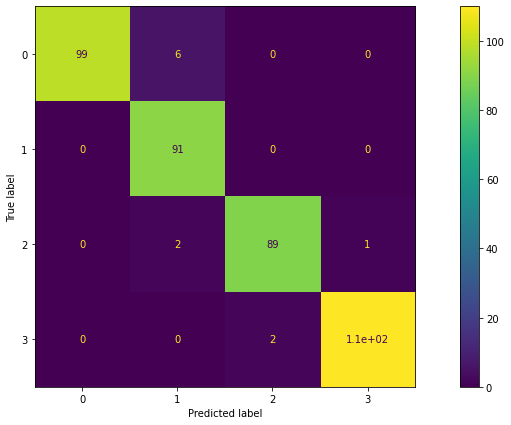

[{'Clase': 0, 'TP': 99, 'FN': 6.0, 'FP': 0.0, 'TN': 295.0}, {'Clase': 1, 'TP': 91, 'FN': 0.0, 'FP': 8.0, 'TN': 301.0}, {'Clase': 2, 'TP': 89, 'FN': 3.0, 'FP': 2.0, 'TN': 306.0}, {'Clase': 3, 'TP': 110, 'FN': 2.0, 'FP': 1.0, 'TN': 287.0}]


In [52]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(svm_model, x_test, y_test)
plt.show()
print(dict_confusion)

## Redes neuronales

### Pre-procesado

In [53]:
data = pd.read_csv('/content/datasets_train.csv').to_numpy()
x = data[:, :-1]
y = data[:, -1].astype('int')

# Normalización: Media y desviación.
sc = StandardScaler()
x = sc.fit_transform(x)
print(x)

# One-hot enconding
y = to_categorical(y)
print(y)

[[-0.90259726 -0.9900495   0.83077942 ... -1.78686097 -1.00601811
   0.98609664]
 [-0.49513857  1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 [-1.5376865   1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 ...
 [ 1.53077336 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
  -1.01409939]
 [ 0.62252745 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
   0.98609664]
 [-1.65833069  1.0100505   0.58562134 ...  0.55964063  0.99401789
   0.98609664]]
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


Hold out

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=42)

print(f"Datos entrenamiento y validacion: {x_train.shape} {y_train.shape}")
print(f"Datos test: {x_test.shape} {y_test.shape}")

Datos entrenamiento y validacion: (1800, 20) (1800, 4)
Datos test: (200, 20) (200, 4)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 1,268
Trainable params: 1,268
Non-trainable params: 0
_________________________________________________________________
----------------------------------------------------------------
Entrenando para el Fold 0
loss of 0.1462930142879486
ac

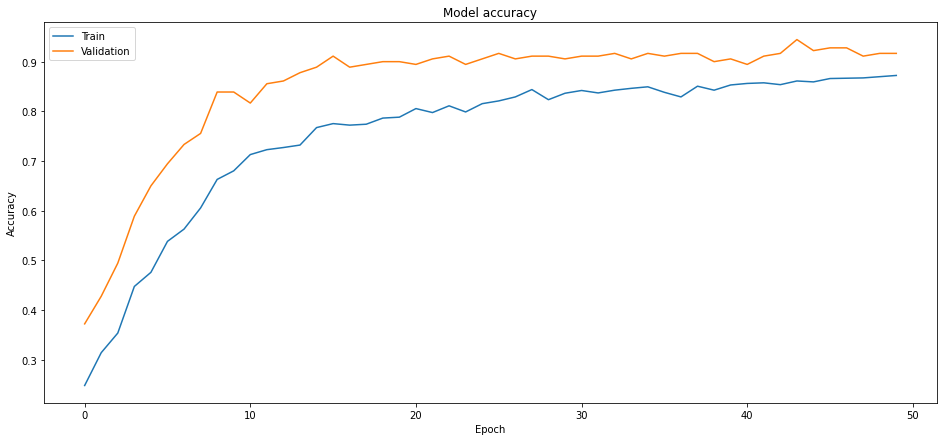

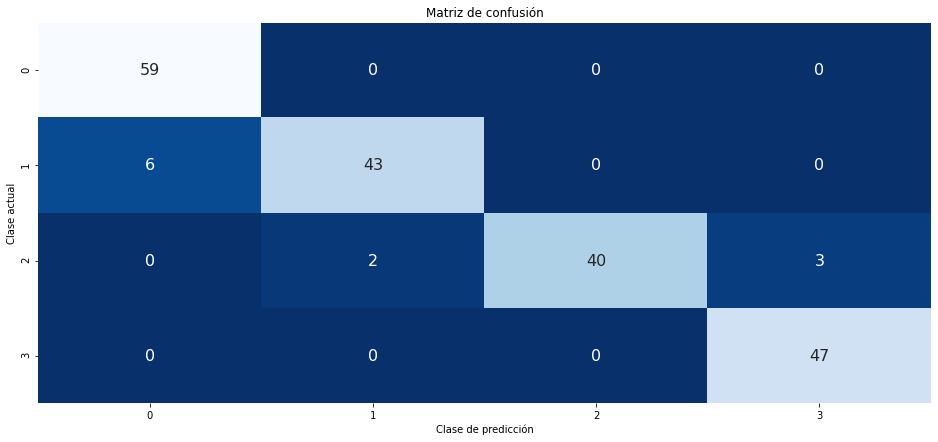

----------------------------------------------------------------
Entrenando para el Fold 1
loss of 0.15170593559741974
accuracy of 93.50000023841858%


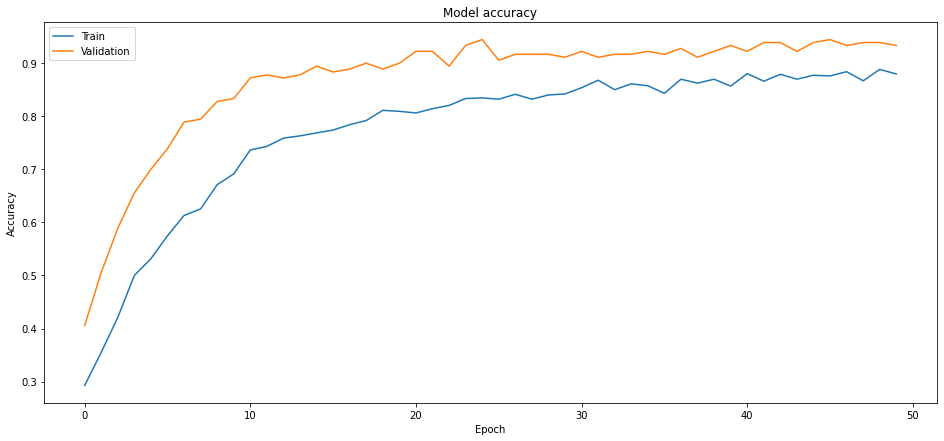

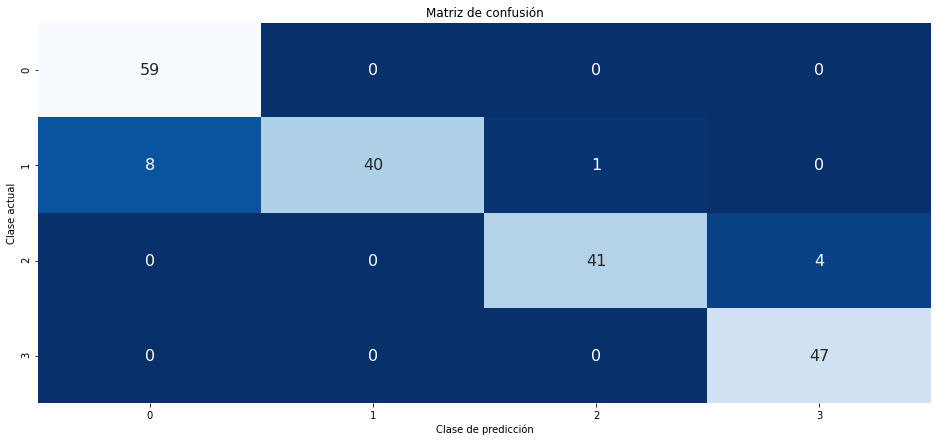

----------------------------------------------------------------
Entrenando para el Fold 2
loss of 0.163681760430336
accuracy of 94.49999928474426%


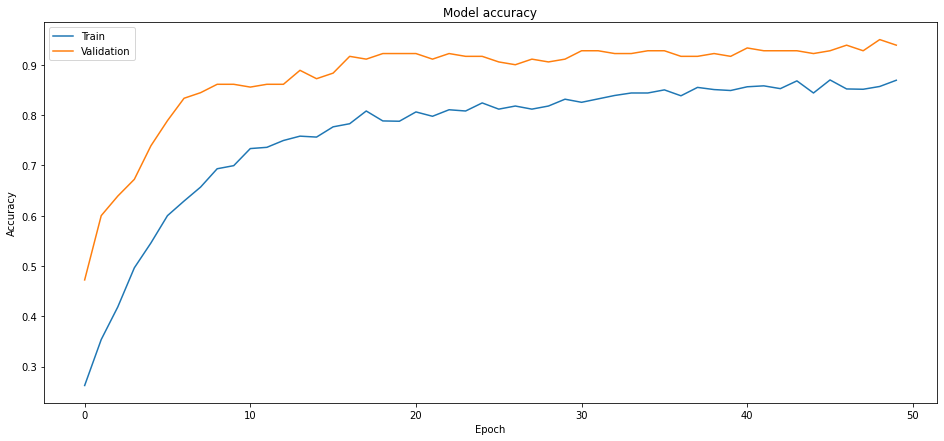

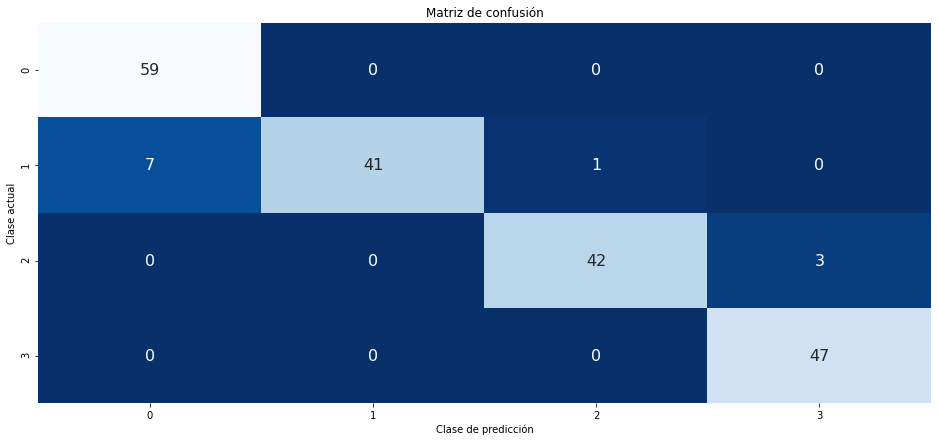

----------------------------------------------------------------
Entrenando para el Fold 3
loss of 0.13937878608703613
accuracy of 94.49999928474426%


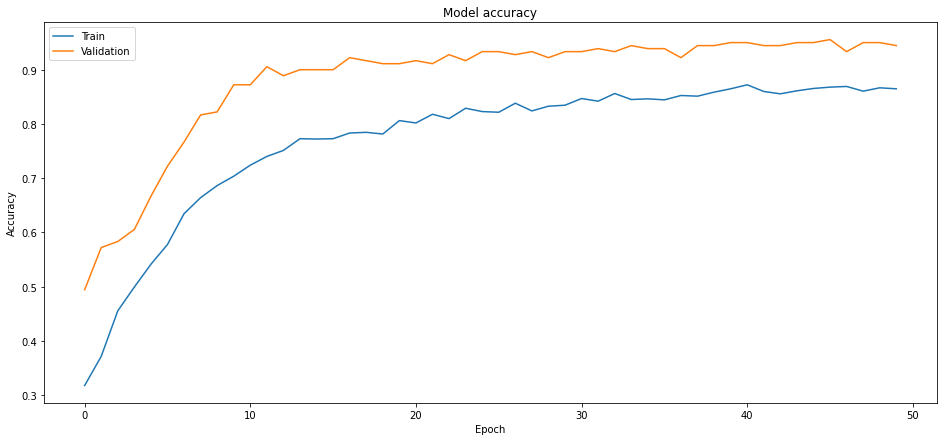

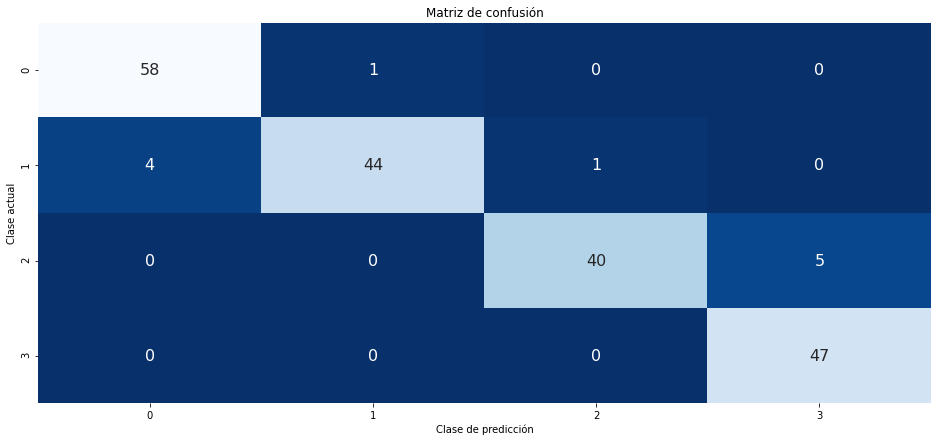

----------------------------------------------------------------
Entrenando para el Fold 4
loss of 0.16806797683238983
accuracy of 92.00000166893005%


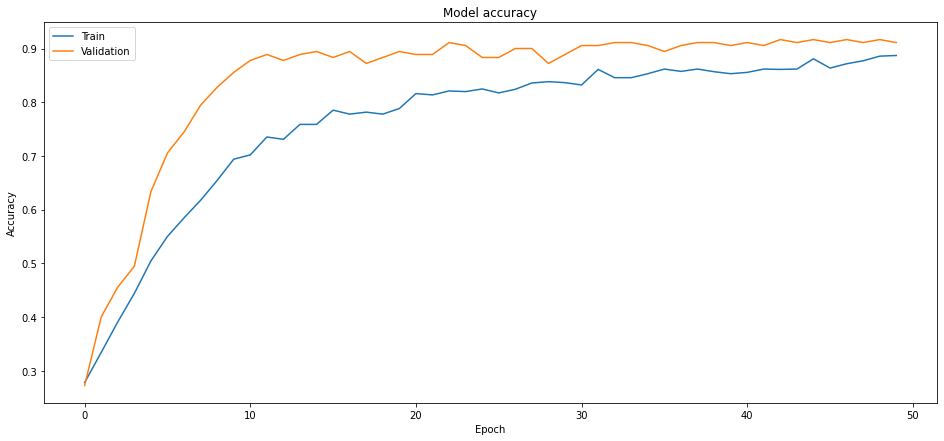

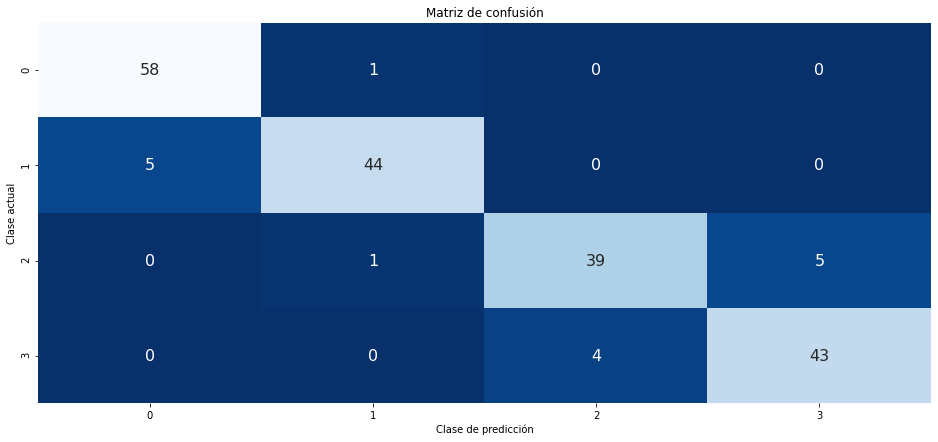

----------------------------------------------------------------
Entrenando para el Fold 5
loss of 0.13526049256324768
accuracy of 94.9999988079071%


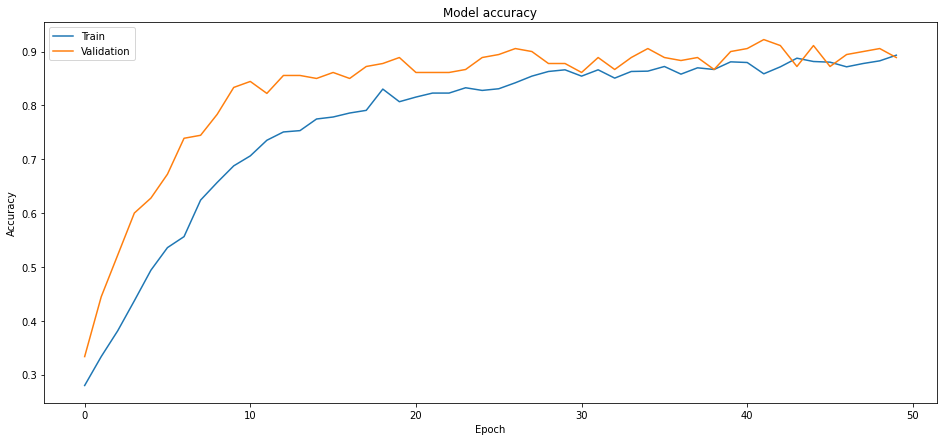

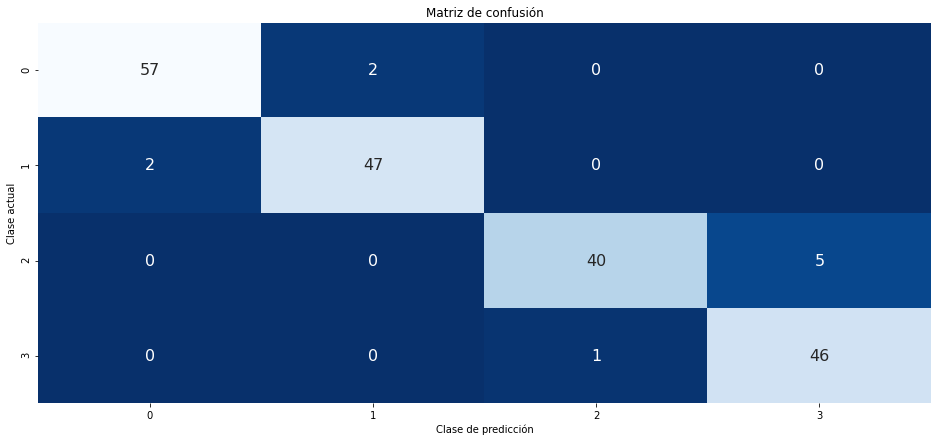

----------------------------------------------------------------
Entrenando para el Fold 6
loss of 0.1935598999261856
accuracy of 91.00000262260437%


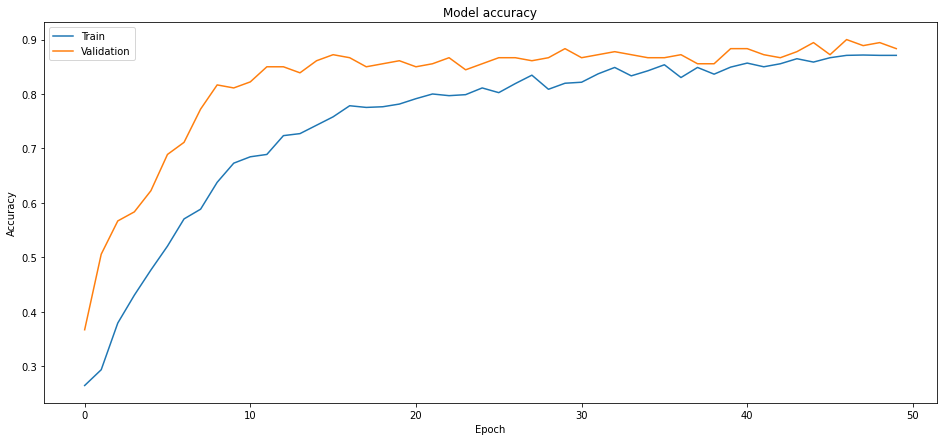

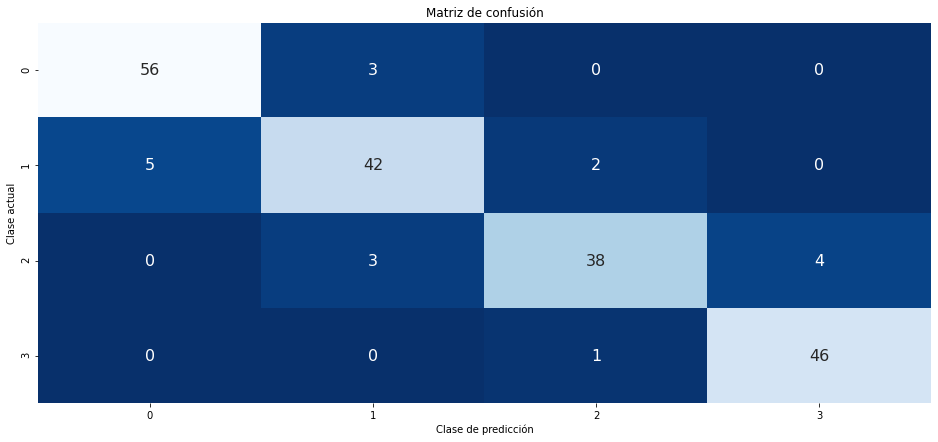

----------------------------------------------------------------
Entrenando para el Fold 7
loss of 0.1778813749551773
accuracy of 91.50000214576721%


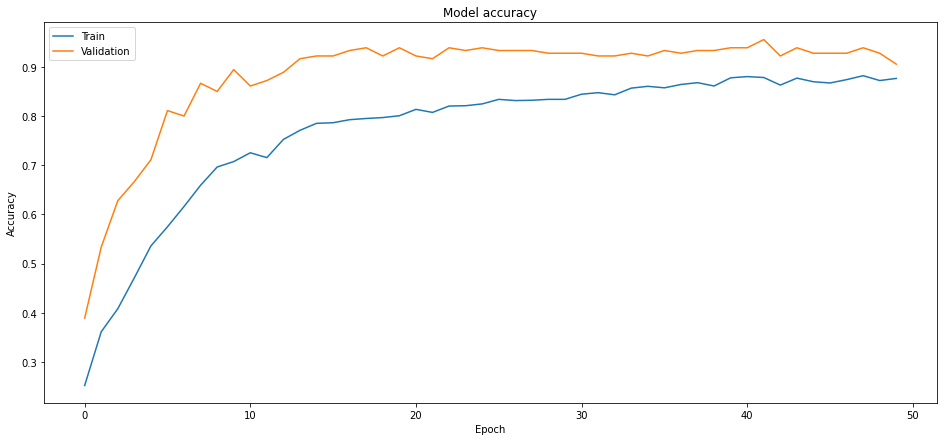

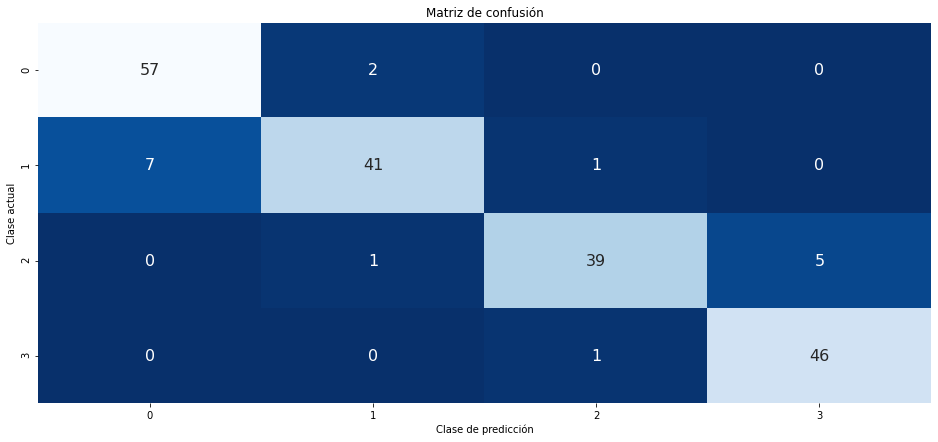

----------------------------------------------------------------
Entrenando para el Fold 8
loss of 0.17110519111156464
accuracy of 92.00000166893005%


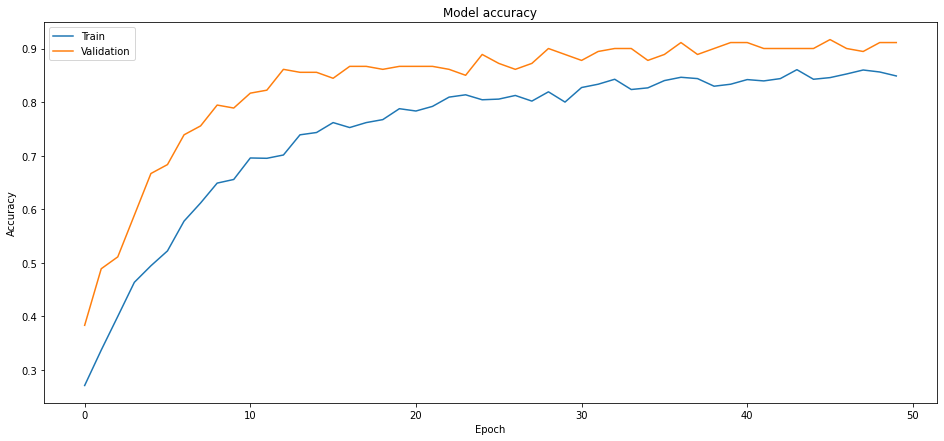

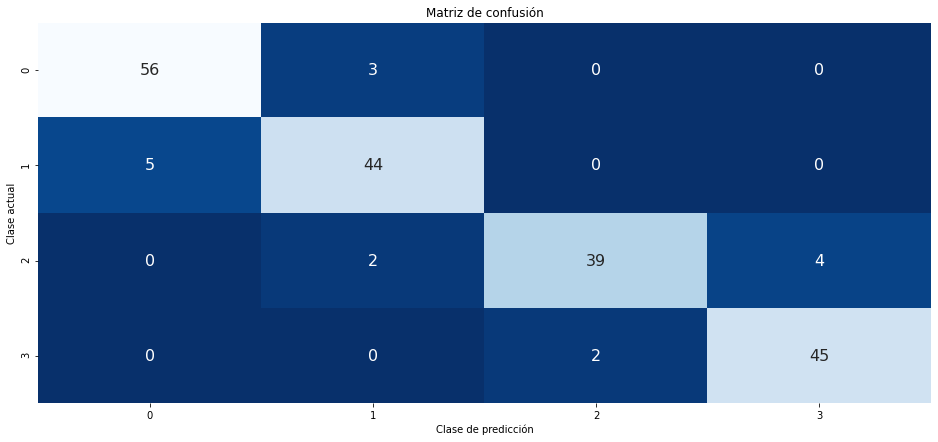

----------------------------------------------------------------
Entrenando para el Fold 9
loss of 0.15481401979923248
accuracy of 93.99999976158142%


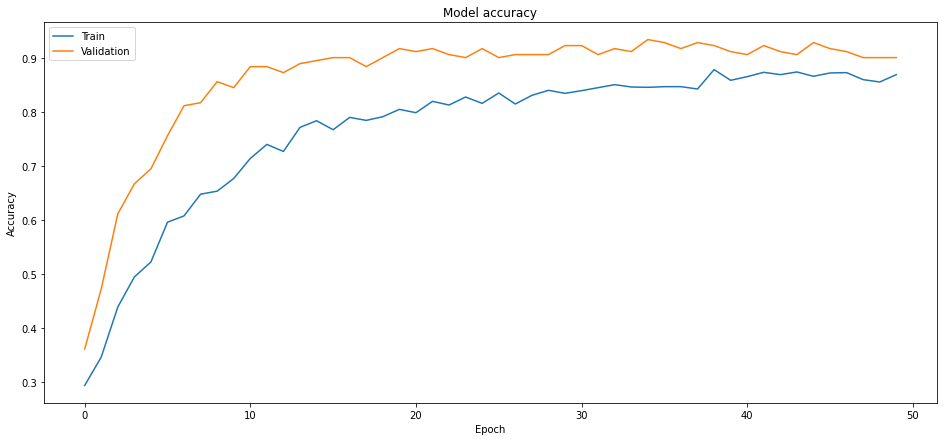

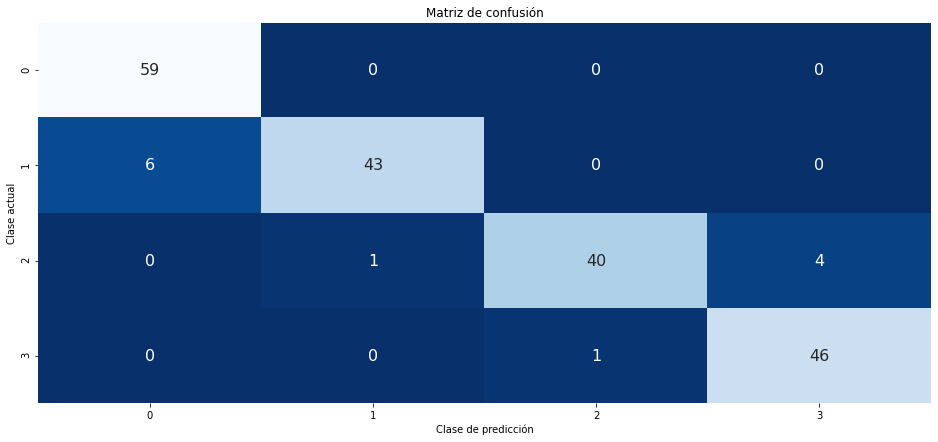


La accuracy media es de 93.25000047683716
La loss media es de 0.1601748451590538


In [55]:
kfold = KFold(n_splits=10, shuffle=True)

fold = 0
accuracy_fold = []
loss_fold = []
for train, validate in kfold.split(x_train, y_train):
    # Datos entrenamiento
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]

    # Datos validacion
    x_valdiate_fold = x_train[validate]
    y_valdiate_fold = y_train[validate]

    # Model
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(x.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Entrenamiento
    history = model.fit(x_train_fold, y_train_fold,
              validation_data=(x_valdiate_fold, y_valdiate_fold),
              batch_size=16,
              epochs=50,
              verbose=0)

    # Test
    prediction_fold = model.evaluate(x_test, y_test, verbose=0)
    y_predicted = model.predict(x_test)

    if fold == 0:
        model.summary()

    print("----------------------------------------------------------------")
    print(f"Entrenando para el Fold {fold}")
    print(f"{model.metrics_names[0]} of {prediction_fold[0]}")
    print(f"{model.metrics_names[1]} of {prediction_fold[1]*100}%")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    mc = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  y_predicted.argmax(axis=1))    
    fig, ax = plt.subplots()
    ax = sb.heatmap(
        mc,
        fmt='.4g',
        annot = True,
        annot_kws={'size': 16},
        cmap= 'Blues_r',
        cbar = False)

    plt.title('Matriz de confusión')
    plt.ylabel('Clase actual')
    plt.xlabel('Clase de predicción')
    plt.ylim(4, 0)
    plt.show()

    accuracy_fold.append(prediction_fold[1] * 100)
    loss_fold.append(prediction_fold[0])

    fold += 1

acc_mean = np.array(accuracy_fold).mean()
loss_mean = np.array(loss_fold).mean()
print(f"\nLa accuracy media es de {acc_mean}")
print(f"La loss media es de {loss_mean}")

Métricas evaluación:
Accuracy: 0.94
Recall: 0.94
F1: 0.94
Specificity: 0.98
Sensibility: 0.94


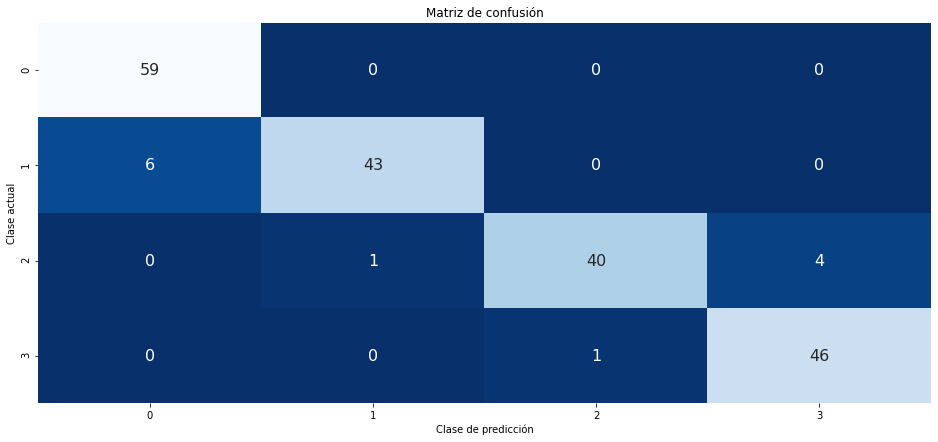

In [61]:
predicted = model.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1))
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1))
recall = metrics.recall_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1), average='micro')
f1 = metrics.f1_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1), average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")


mc = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  y_predicted.argmax(axis=1))    
fig, ax = plt.subplots()
ax = sb.heatmap(
    mc,
    fmt='.4g',
    annot = True,
    annot_kws={'size': 16},
    cmap= 'Blues_r',
    cbar = False)

plt.title('Matriz de confusión')
plt.ylabel('Clase actual')
plt.xlabel('Clase de predicción')
plt.ylim(4, 0)
plt.show()